In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time


In [2]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

from sklearn.impute import KNNImputer


2024-09-19 16:45:32.663525: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 16:45:32.703293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 16:45:33.286787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [34]:

# Load the dataset
df = pd.read_csv('R3.csv')
mn= df['Material name']
df = df.drop(columns=['Material name'])

# Replace empty strings with NaN
df = df.replace(' ', np.nan)

# Convert all columns to numeric, coercing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Separate the features and target variables if needed
# Here, assuming all columns except 'Material name' are features
df.head()

,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,TiO2,MnO,K2O,Na2O,...,Ca(OH)2,CaCO3,Water,K2SO4,KOH,curing temp,age,heat release,CH consumption,Bound water
0,55.70,23.71,3.75,10.50,1.00,0.25,0.71,NaN,0.81,2.46,...,3.0,0.0,3.6,0.0,0.151,50,10.0,NaN,60.478088,NaN
1,41.62,21.30,8.14,17.13,2.84,1.59,1.28,NaN,1.49,1.01,...,3.0,0.0,3.6,0.0,0.151,50,10.0,NaN,67.649402,NaN
2,35.48,18.36,5.27,20.38,4.09,2.73,1.11,NaN,0.81,6.69,...,3.0,0.0,3.6,0.0,0.151,50,10.0,NaN,62.071713,NaN
3,56.76,20.51,6.21,9.74,2.59,0.46,1.17,NaN,1.35,0.69,...,3.0,0.0,3.6,0.0,0.151,50,10.0,NaN,55.697211,NaN
4,32.59,13.94,0.78,42.22,4.96,2.02,0.58,NaN,0.37,0.23,...,3.0,0.0,3.6,0.0,0.151,50,10.0,NaN,23.027888,NaN


In [4]:

# Separate features and targets
X = df.drop(columns=['heat release', 'CH consumption', 'Bound water'])
y = df[['heat release', 'CH consumption', 'Bound water']]


In [5]:
X

,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,TiO2,MnO,K2O,Na2O,...,S gravity,Amorphous content,d50,Ca(OH)2,CaCO3,Water,K2SO4,KOH,curing temp,age
0,55.70,23.71,3.75,10.50,1.00,0.25,0.71,NaN,0.81,2.46,...,NaN,NaN,27.20,3.00,0.000000,3.600000,0.000000,0.151,50,10.0
1,41.62,21.30,8.14,17.13,2.84,1.59,1.28,NaN,1.49,1.01,...,NaN,NaN,19.20,3.00,0.000000,3.600000,0.000000,0.151,50,10.0
2,35.48,18.36,5.27,20.38,4.09,2.73,1.11,NaN,0.81,6.69,...,NaN,NaN,12.40,3.00,0.000000,3.600000,0.000000,0.151,50,10.0
3,56.76,20.51,6.21,9.74,2.59,0.46,1.17,NaN,1.35,0.69,...,NaN,NaN,14.60,3.00,0.000000,3.600000,0.000000,0.151,50,10.0
4,32.59,13.94,0.78,42.22,4.96,2.02,0.58,NaN,0.37,0.23,...,NaN,NaN,13.70,3.00,0.000000,3.600000,0.000000,0.151,50,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,43.30,7.90,NaN,36.00,9.80,NaN,0.60,NaN,NaN,NaN,...,NaN,100.0,NaN,3.00,0.000000,5.000000,0.100000,0.200,40,1.0
1844,30.20,13.10,NaN,45.80,7.38,NaN,NaN,NaN,0.41,NaN,...,NaN,NaN,14.14,3.03,0.505455,5.454545,0.109091,0.020,40,NaN
1845,65.50,2.09,0.21,6.09,3.44,NaN,NaN,NaN,1.47,19.60,...,NaN,NaN,11.40,3.03,0.505455,5.454545,0.109091,0.020,40,NaN
1846,65.70,1.93,0.87,11.70,1.72,NaN,NaN,NaN,0.78,16.80,...,NaN,NaN,7.84,3.03,0.505455,5.454545,0.109091,0.020,40,NaN


In [6]:
input_mask = X.notnull().astype(int).values


In [7]:
import pickle

# Load the imputed X matrix from the pickle file
with open('df_imputed.pkl', 'rb') as file:
    df_imputed = pickle.load(file)
# Normalize features
scaler = StandardScaler()

X_imputed = df_imputed.drop(columns=['heat release', 'CH consumption', 'Bound water'])
X_scaled = scaler.fit_transform(X_imputed)




In [11]:
X_imputed

,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,TiO2,MnO,K2O,Na2O,...,S gravity,Amorphous content,d50,Ca(OH)2,CaCO3,Water,K2SO4,KOH,curing temp,age
0,55.70,23.71,3.750000,10.50,1.00,0.250000,0.710000,0.068990,0.810000,2.460000,...,2.525563,88.563568,27.200000,3.00,0.000000,3.600000,0.000000,0.151,50.0,10.000000
1,41.62,21.30,8.140000,17.13,2.84,1.590000,1.280000,0.082114,1.490000,1.010000,...,2.529600,84.360756,19.200000,3.00,0.000000,3.600000,0.000000,0.151,50.0,10.000000
2,35.48,18.36,5.270000,20.38,4.09,2.730000,1.110000,0.247530,0.810000,6.690000,...,2.560097,82.638313,12.400000,3.00,0.000000,3.600000,0.000000,0.151,50.0,10.000000
3,56.76,20.51,6.210000,9.74,2.59,0.460000,1.170000,0.073591,1.350000,0.690000,...,2.484917,88.772125,14.600000,3.00,0.000000,3.600000,0.000000,0.151,50.0,10.000000
4,32.59,13.94,0.780000,42.22,4.96,2.020000,0.580000,0.095472,0.370000,0.230000,...,2.940874,97.638580,13.700000,3.00,0.000000,3.600000,0.000000,0.151,50.0,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,43.30,7.90,2.376508,36.00,9.80,2.701621,0.600000,1.606990,1.330275,0.304034,...,2.899762,100.000000,29.547108,3.00,0.000000,5.000000,0.100000,0.200,40.0,1.000000
1844,30.20,13.10,4.716980,45.80,7.38,2.607091,0.660977,0.288351,0.410000,0.816456,...,3.032587,74.774376,14.140000,3.03,0.505455,5.454545,0.109091,0.020,40.0,0.679309
1845,65.50,2.09,0.210000,6.09,3.44,1.413401,0.049860,0.201595,1.470000,19.600000,...,2.590849,88.130096,11.400000,3.03,0.505455,5.454545,0.109091,0.020,40.0,5.840166
1846,65.70,1.93,0.870000,11.70,1.72,1.549747,0.102306,0.200604,0.780000,16.800000,...,2.539541,90.091408,7.840000,3.03,0.505455,5.454545,0.109091,0.020,40.0,5.903069


/tmp/ipykernel_2589467/2304838734.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # Use a clean white style
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


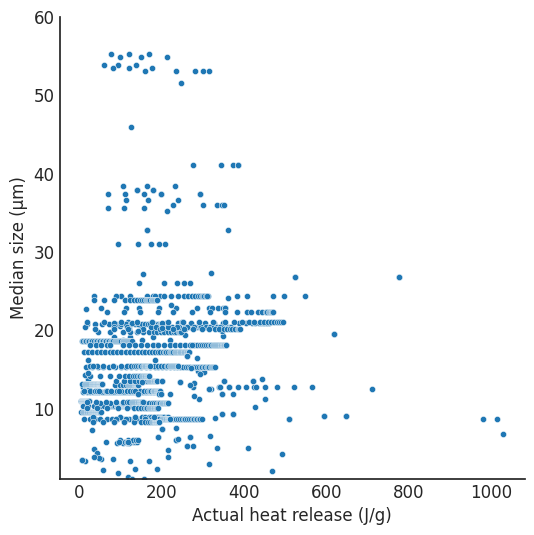

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot for training data
# Set the aesthetic style of the plots
plt.style.use('seaborn-white')  # Use a clean white style
sns.set_style("ticks")  # Use ticks style for a more refined look
plt.rcParams['font.family'] = 'sans-serif'  # Use a sans-serif font for a modern look
plt.rcParams['font.size'] = 12  # Adjust font size for readability

fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the size for a square aspect ratio

sns.scatterplot(y='d50', x='heat release',  data=df, s=20)
ax.set_xlabel('Actual heat release (J/g)')
ax.set_ylabel('Median size (µm)')


plt.ylim(0,100)
plt.ylim(1,60)

ax.legend(frameon=False,prop={'size': 12})  # Remove the legend frame for a cleaner look
sns.despine()  # Remove the top and right spines

In [8]:

mean_heat_release = y['heat release'].mean()
std_heat_release = y['heat release'].std()

mean_ch_consumption = y['CH consumption'].mean()
std_ch_consumption = y['CH consumption'].std()

mean_bound_water = y['Bound water'].mean()
std_bound_water = y['Bound water'].std()

# Training set
y['heat release'] = (y['heat release'] - mean_heat_release) / std_heat_release
y['CH consumption'] = (y['CH consumption'] - mean_ch_consumption) / std_ch_consumption
y['Bound water'] = (y['Bound water'] - mean_bound_water) / std_bound_water


/tmp/ipykernel_2589467/257046621.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['heat release'] = (y['heat release'] - mean_heat_release) / std_heat_release
/tmp/ipykernel_2589467/257046621.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['CH consumption'] = (y['CH consumption'] - mean_ch_consumption) / std_ch_consumption
/tmp/ipykernel_2589467/257046621.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [9]:
def custom_nan_mse(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    mask = tf.cast(mask, dtype=tf.float32)
    
    y_true = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)
    squared_difference = tf.square(y_true - y_pred) * mask
    
    # Add a small constant (epsilon) to avoid division by zero
    epsilon = 1e-7
    return tf.reduce_sum(squared_difference) / (tf.reduce_sum(mask) + epsilon)

def custom_nan_nrmse(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    mask = tf.cast(mask, dtype=tf.float32)
    
    y_true = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)
    squared_difference = tf.square(y_true - y_pred) * mask
    mse = tf.reduce_sum(squared_difference) / tf.reduce_sum(mask)
    rmse = tf.sqrt(mse)
    
    # Mask y_true values, replacing masked values with infinity and negative infinity
    # to ensure they don't affect the min and max calculations
    y_true_masked_min = tf.where(mask > 0, y_true, tf.fill(tf.shape(y_true), tf.float32.max))
    y_true_masked_max = tf.where(mask > 0, y_true, tf.fill(tf.shape(y_true), tf.float32.min))
    
    # Compute the min and max of the non-NaN y_true values
    y_true_min = tf.reduce_min(y_true_masked_min)
    y_true_max = tf.reduce_max(y_true_masked_max)
    
    y_range = y_true_max - y_true_min
    epsilon = 1e-7
    nrmse = rmse / (y_range + epsilon)
    
    return nrmse




In [10]:
def unstandardize(values, mean, std):
    """Convert standardized values back to the original scale."""
    return values * std + mean

In [1044]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

# Assuming custom_nan_mse, custom_nan_nrmse, weight_heat_release, weight_ch_consumption, and weight_bound_water are defined elsewhere

# Define input layers for features and their masks
input_features = Input(shape=(X_scaled.shape[1],), name='Input_Features')
input_masks = Input(shape=(X_scaled.shape[1],), name='Input_Masks')

# Combine the inputs and masks by concatenation
combined_inputs = concatenate([input_features, input_masks])

# Define the rest of the model
hidden1 = Dense(256, activation='relu')(combined_inputs)
hidden2 = Dropout(0.1)(hidden1)

hidden3 = Dense(256, activation='relu')(hidden2)
hidden4 = Dense(16, activation='relu')(hidden3)

# Define the output layers with names
Heat_Release_Output = Dense(1, name='Heat_Release_Output')(hidden4)
CH_Consumption_Output = Dense(1, name='CH_Consumption_Output')(hidden4)
Bound_Water_Output = Dense(1, name='Bound_Water_Output')(hidden4)

# Create the model
model = Model(inputs=[input_features, input_masks], 
              outputs=[Heat_Release_Output, CH_Consumption_Output, Bound_Water_Output])

# Assuming these are the counts of non-NaN data points for each target
count_heat_release = np.count_nonzero(~np.isnan(y_train['heat release']))
count_ch_consumption = np.count_nonzero(~np.isnan(y_train['CH consumption']))
count_bound_water = np.count_nonzero(~np.isnan(y_train['Bound water']))

# Calculate the total count for normalization
total_count = count_heat_release + count_ch_consumption + count_bound_water

global weight_heat_release, weight_ch_consumption, weight_bound_water

# Calculate loss weights inversely proportional to the number of data points
weight_heat_release = (total_count - count_heat_release) / total_count
weight_ch_consumption = (total_count - count_ch_consumption) / total_count
weight_bound_water = (total_count - count_bound_water) / total_count
# Compile the model with specified loss weights
model.compile(optimizer='adam',
              loss={'Heat_Release_Output': custom_nan_mse,
                    'CH_Consumption_Output': custom_nan_mse,
                    'Bound_Water_Output': custom_nan_mse},
              loss_weights={'Heat_Release_Output': weight_heat_release,
                            'CH_Consumption_Output': weight_ch_consumption*5,
                            'Bound_Water_Output': weight_bound_water},
              metrics={'Heat_Release_Output': [custom_nan_mse, custom_nan_nrmse],
                       'CH_Consumption_Output': [custom_nan_mse, custom_nan_nrmse],
                       'Bound_Water_Output': [custom_nan_mse, custom_nan_nrmse]})


In [1045]:
weight_bound_water

0.8408469945355191

In [1046]:
# Split the data and masks into training and testing sets

# Create masks for input features (1 for present values, 0 for missing values)

from tensorflow.keras.callbacks import EarlyStopping

# Split the data and masks into training and testing sets
# Split the data and masks into training and testing sets

num_bins = 5
bins_heat_release = np.linspace(df_imputed['heat release'].min(), df_imputed['heat release'].max(), num_bins)
bins_ch_consumption = np.linspace(df_imputed['CH consumption'].min(), df_imputed['CH consumption'].max(), num_bins)
bins_bound_water = np.linspace(df_imputed['Bound water'].min(), df_imputed['Bound water'].max(), num_bins)

# Initialize yy as a dictionary
yy = {}

# Digitize (bin) each target
yy['heat_release_binned'] = np.digitize(y['heat release'], bins_heat_release)
yy['ch_consumption_binned'] = np.digitize(y['CH consumption'], bins_ch_consumption)
yy['bound_water_binned'] = np.digitize(y['Bound water'], bins_bound_water)

# Calculate the maximum number of bins to set the radix
max_bins = max(bins_heat_release.size, bins_ch_consumption.size, bins_bound_water.size)

# Create a combined stratification key as a single integer
stratify_key = yy['heat_release_binned'] + \
               (yy['ch_consumption_binned'] * max_bins) + \
               (yy['bound_water_binned'] * (max_bins ** 2))
# Create masks for input features (1 for present values, 0 for missing values)
input_mask = X.notnull().astype(int).values
X_train, X_test, mask_train, mask_test, y_train, y_test = train_test_split(
    X_scaled, input_mask, y, test_size=0.2, random_state=42, stratify =stratify_key)
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
early_stopping = EarlyStopping(
    monitor='val_CH_Consumption_Output_custom_nan_nrmse',  # Metric to monitor
    patience=200,         # Number of epochs to wait after min has been hit
    mode='min',          # Stop when the monitored quantity has stopped decreasing
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

model.fit([X_train, mask_train], 
                       {'Heat_Release_Output': y_train['heat release'],
                        'CH_Consumption_Output': y_train['CH consumption'],
                        'Bound_Water_Output': y_train['Bound water']},
                       epochs=10000, 
                       batch_size=50, 
                       validation_split=0.15,
                       callbacks=[early_stopping])  # Set verbose to 0 to reduce training output
    

Epoch 1/10000
26/26 [==============================] - 1s 13ms/step - loss: 4.1490 - Heat_Release_Output_loss: 0.8566 - CH_Consumption_Output_loss: 0.6957 - Bound_Water_Output_loss: 0.9866 - Heat_Release_Output_custom_nan_mse: 0.8345 - Heat_Release_Output_custom_nan_nrmse: 0.2408 - CH_Consumption_Output_custom_nan_mse: 0.6803 - CH_Consumption_Output_custom_nan_nrmse: 181180.5156 - Bound_Water_Output_custom_nan_mse: 0.9532 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 4.9886 - val_Heat_Release_Output_loss: 1.1231 - val_CH_Consumption_Output_loss: 0.9310 - val_Bound_Water_Output_loss: 0.6577 - val_Heat_Release_Output_custom_nan_mse: 1.0478 - val_Heat_Release_Output_custom_nan_nrmse: 0.2171 - val_CH_Consumption_Output_custom_nan_mse: 0.8374 - val_CH_Consumption_Output_custom_nan_nrmse: 0.4394 - val_Bound_Water_Output_custom_nan_mse: 0.6878 - val_Bound_Water_Output_custom_nan_nrmse: 1.6910
Epoch 2/10000
26/26 [==============================] - 0s 3ms/step - loss: 3.2717 - Heat_Rel

26/26 [==============================] - 0s 3ms/step - loss: 1.1597 - Heat_Release_Output_loss: 0.3799 - CH_Consumption_Output_loss: 0.2050 - Bound_Water_Output_loss: 0.1745 - Heat_Release_Output_custom_nan_mse: 0.3790 - Heat_Release_Output_custom_nan_nrmse: 0.1566 - CH_Consumption_Output_custom_nan_mse: 0.1982 - CH_Consumption_Output_custom_nan_nrmse: 19563.3398 - Bound_Water_Output_custom_nan_mse: 0.1686 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 2.9776 - val_Heat_Release_Output_loss: 0.5024 - val_CH_Consumption_Output_loss: 0.6037 - val_Bound_Water_Output_loss: 0.1935 - val_Heat_Release_Output_custom_nan_mse: 0.4549 - val_Heat_Release_Output_custom_nan_nrmse: 0.1308 - val_CH_Consumption_Output_custom_nan_mse: 0.5437 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2950 - val_Bound_Water_Output_custom_nan_mse: 0.1978 - val_Bound_Water_Output_custom_nan_nrmse: 0.8575
Epoch 20/10000
26/26 [==============================] - 0s 3ms/step - loss: 1.1296 - Heat_Release_Output_los

26/26 [==============================] - 0s 3ms/step - loss: 0.2764 - Heat_Release_Output_loss: 0.2173 - CH_Consumption_Output_loss: 0.0351 - Bound_Water_Output_loss: 0.0733 - Heat_Release_Output_custom_nan_mse: 0.2135 - Heat_Release_Output_custom_nan_nrmse: 0.1204 - CH_Consumption_Output_custom_nan_mse: 0.0339 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0766 - Bound_Water_Output_custom_nan_nrmse: 152120.1719 - val_loss: 2.1462 - val_Heat_Release_Output_loss: 0.3102 - val_CH_Consumption_Output_loss: 0.4479 - val_Bound_Water_Output_loss: 0.0890 - val_Heat_Release_Output_custom_nan_mse: 0.2829 - val_Heat_Release_Output_custom_nan_nrmse: 0.1069 - val_CH_Consumption_Output_custom_nan_mse: 0.4523 - val_CH_Consumption_Output_custom_nan_nrmse: 0.5544 - val_Bound_Water_Output_custom_nan_mse: 0.0846 - val_Bound_Water_Output_custom_nan_nrmse: 0.4428
Epoch 38/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.3169 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.2175 - Heat_Release_Output_loss: 0.1728 - CH_Consumption_Output_loss: 0.0298 - Bound_Water_Output_loss: 0.0457 - Heat_Release_Output_custom_nan_mse: 0.1678 - Heat_Release_Output_custom_nan_nrmse: 0.1023 - CH_Consumption_Output_custom_nan_mse: 0.0288 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0442 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.6933 - val_Heat_Release_Output_loss: 0.2479 - val_CH_Consumption_Output_loss: 0.3493 - val_Bound_Water_Output_loss: 0.0905 - val_Heat_Release_Output_custom_nan_mse: 0.2256 - val_Heat_Release_Output_custom_nan_nrmse: 0.0949 - val_CH_Consumption_Output_custom_nan_mse: 0.3428 - val_CH_Consumption_Output_custom_nan_nrmse: 0.4185 - val_Bound_Water_Output_custom_nan_mse: 0.0966 - val_Bound_Water_Output_custom_nan_nrmse: 0.6551
Epoch 56/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.2568 - Heat_Release_Output_loss: 0.15

26/26 [==============================] - 0s 3ms/step - loss: 0.2262 - Heat_Release_Output_loss: 0.1262 - CH_Consumption_Output_loss: 0.0350 - Bound_Water_Output_loss: 0.0437 - Heat_Release_Output_custom_nan_mse: 0.1224 - Heat_Release_Output_custom_nan_nrmse: 0.1026 - CH_Consumption_Output_custom_nan_mse: 0.0341 - CH_Consumption_Output_custom_nan_nrmse: 0.1395 - Bound_Water_Output_custom_nan_mse: 0.0422 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.6102 - val_Heat_Release_Output_loss: 0.1960 - val_CH_Consumption_Output_loss: 0.3341 - val_Bound_Water_Output_loss: 0.0888 - val_Heat_Release_Output_custom_nan_mse: 0.1829 - val_Heat_Release_Output_custom_nan_nrmse: 0.0924 - val_CH_Consumption_Output_custom_nan_mse: 0.3183 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3877 - val_Bound_Water_Output_custom_nan_mse: 0.1020 - val_Bound_Water_Output_custom_nan_nrmse: 0.7422
Epoch 74/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.2096 - Heat_Release_Output_loss: 0

26/26 [==============================] - 0s 3ms/step - loss: 0.2232 - Heat_Release_Output_loss: 0.1084 - CH_Consumption_Output_loss: 0.0349 - Bound_Water_Output_loss: 0.0460 - Heat_Release_Output_custom_nan_mse: 0.1098 - Heat_Release_Output_custom_nan_nrmse: 0.0828 - CH_Consumption_Output_custom_nan_mse: 0.0338 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0446 - Bound_Water_Output_custom_nan_nrmse: 16756.3984 - val_loss: 1.7579 - val_Heat_Release_Output_loss: 0.1661 - val_CH_Consumption_Output_loss: 0.3620 - val_Bound_Water_Output_loss: 0.1271 - val_Heat_Release_Output_custom_nan_mse: 0.1523 - val_Heat_Release_Output_custom_nan_nrmse: 0.0797 - val_CH_Consumption_Output_custom_nan_mse: 0.3567 - val_CH_Consumption_Output_custom_nan_nrmse: 0.4343 - val_Bound_Water_Output_custom_nan_mse: 0.1512 - val_Bound_Water_Output_custom_nan_nrmse: 0.9702
Epoch 92/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.4380 - Heat_Release_Output_los

26/26 [==============================] - 0s 3ms/step - loss: 0.1510 - Heat_Release_Output_loss: 0.0960 - CH_Consumption_Output_loss: 0.0236 - Bound_Water_Output_loss: 0.0242 - Heat_Release_Output_custom_nan_mse: 0.0968 - Heat_Release_Output_custom_nan_nrmse: 0.0868 - CH_Consumption_Output_custom_nan_mse: 0.0228 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0243 - Bound_Water_Output_custom_nan_nrmse: 53011.8672 - val_loss: 1.8076 - val_Heat_Release_Output_loss: 0.1279 - val_CH_Consumption_Output_loss: 0.3833 - val_Bound_Water_Output_loss: 0.0860 - val_Heat_Release_Output_custom_nan_mse: 0.1181 - val_Heat_Release_Output_custom_nan_nrmse: 0.0730 - val_CH_Consumption_Output_custom_nan_mse: 0.3690 - val_CH_Consumption_Output_custom_nan_nrmse: 0.4293 - val_Bound_Water_Output_custom_nan_mse: 0.0989 - val_Bound_Water_Output_custom_nan_nrmse: 0.7814
Epoch 110/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1444 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.1422 - Heat_Release_Output_loss: 0.0791 - CH_Consumption_Output_loss: 0.0214 - Bound_Water_Output_loss: 0.0304 - Heat_Release_Output_custom_nan_mse: 0.0775 - Heat_Release_Output_custom_nan_nrmse: 0.0714 - CH_Consumption_Output_custom_nan_mse: 0.0213 - CH_Consumption_Output_custom_nan_nrmse: 43718.4102 - Bound_Water_Output_custom_nan_mse: 0.0293 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.6926 - val_Heat_Release_Output_loss: 0.1148 - val_CH_Consumption_Output_loss: 0.3566 - val_Bound_Water_Output_loss: 0.0942 - val_Heat_Release_Output_custom_nan_mse: 0.1048 - val_Heat_Release_Output_custom_nan_nrmse: 0.0663 - val_CH_Consumption_Output_custom_nan_mse: 0.3311 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3351 - val_Bound_Water_Output_custom_nan_mse: 0.1157 - val_Bound_Water_Output_custom_nan_nrmse: 0.8882
Epoch 128/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1246 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.1059 - Heat_Release_Output_loss: 0.0795 - CH_Consumption_Output_loss: 0.0141 - Bound_Water_Output_loss: 0.0260 - Heat_Release_Output_custom_nan_mse: 0.0798 - Heat_Release_Output_custom_nan_nrmse: 0.0770 - CH_Consumption_Output_custom_nan_mse: 0.0136 - CH_Consumption_Output_custom_nan_nrmse: 9137.3379 - Bound_Water_Output_custom_nan_mse: 0.0258 - Bound_Water_Output_custom_nan_nrmse: 44636.8828 - val_loss: 1.7053 - val_Heat_Release_Output_loss: 0.1022 - val_CH_Consumption_Output_loss: 0.3606 - val_Bound_Water_Output_loss: 0.0922 - val_Heat_Release_Output_custom_nan_mse: 0.0932 - val_Heat_Release_Output_custom_nan_nrmse: 0.0623 - val_CH_Consumption_Output_custom_nan_mse: 0.3354 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3414 - val_Bound_Water_Output_custom_nan_mse: 0.1182 - val_Bound_Water_Output_custom_nan_nrmse: 0.9231
Epoch 146/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1446 - Heat_Release_Out

26/26 [==============================] - 0s 2ms/step - loss: 0.1483 - Heat_Release_Output_loss: 0.0744 - CH_Consumption_Output_loss: 0.0229 - Bound_Water_Output_loss: 0.0313 - Heat_Release_Output_custom_nan_mse: 0.0720 - Heat_Release_Output_custom_nan_nrmse: 0.0658 - CH_Consumption_Output_custom_nan_mse: 0.0222 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0314 - Bound_Water_Output_custom_nan_nrmse: 0.0724 - val_loss: 1.4796 - val_Heat_Release_Output_loss: 0.1498 - val_CH_Consumption_Output_loss: 0.3116 - val_Bound_Water_Output_loss: 0.0669 - val_Heat_Release_Output_custom_nan_mse: 0.1338 - val_Heat_Release_Output_custom_nan_nrmse: 0.0656 - val_CH_Consumption_Output_custom_nan_mse: 0.2927 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3483 - val_Bound_Water_Output_custom_nan_mse: 0.0900 - val_Bound_Water_Output_custom_nan_nrmse: 0.8671
Epoch 164/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1349 - Heat_Release_Output_loss: 

26/26 [==============================] - 0s 3ms/step - loss: 0.1201 - Heat_Release_Output_loss: 0.0588 - CH_Consumption_Output_loss: 0.0191 - Bound_Water_Output_loss: 0.0230 - Heat_Release_Output_custom_nan_mse: 0.0569 - Heat_Release_Output_custom_nan_nrmse: 0.0579 - CH_Consumption_Output_custom_nan_mse: 0.0185 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0222 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.7075 - val_Heat_Release_Output_loss: 0.1093 - val_CH_Consumption_Output_loss: 0.3657 - val_Bound_Water_Output_loss: 0.0658 - val_Heat_Release_Output_custom_nan_mse: 0.0983 - val_Heat_Release_Output_custom_nan_nrmse: 0.0597 - val_CH_Consumption_Output_custom_nan_mse: 0.3374 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3276 - val_Bound_Water_Output_custom_nan_mse: 0.0890 - val_Bound_Water_Output_custom_nan_nrmse: 0.8513
Epoch 182/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1337 - Heat_Release_Output_loss: 0.0

26/26 [==============================] - 0s 3ms/step - loss: 0.1054 - Heat_Release_Output_loss: 0.0539 - CH_Consumption_Output_loss: 0.0158 - Bound_Water_Output_loss: 0.0247 - Heat_Release_Output_custom_nan_mse: 0.0538 - Heat_Release_Output_custom_nan_nrmse: 0.0606 - CH_Consumption_Output_custom_nan_mse: 0.0152 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0239 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.5795 - val_Heat_Release_Output_loss: 0.0944 - val_CH_Consumption_Output_loss: 0.3408 - val_Bound_Water_Output_loss: 0.0496 - val_Heat_Release_Output_custom_nan_mse: 0.0865 - val_Heat_Release_Output_custom_nan_nrmse: 0.0604 - val_CH_Consumption_Output_custom_nan_mse: 0.3150 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3279 - val_Bound_Water_Output_custom_nan_mse: 0.0664 - val_Bound_Water_Output_custom_nan_nrmse: 0.7474
Epoch 200/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0975 - Heat_Release_Output_loss: 0.0

26/26 [==============================] - 0s 3ms/step - loss: 0.0815 - Heat_Release_Output_loss: 0.0543 - CH_Consumption_Output_loss: 0.0100 - Bound_Water_Output_loss: 0.0268 - Heat_Release_Output_custom_nan_mse: 0.0540 - Heat_Release_Output_custom_nan_nrmse: 0.0614 - CH_Consumption_Output_custom_nan_mse: 0.0097 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0259 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.6754 - val_Heat_Release_Output_loss: 0.0928 - val_CH_Consumption_Output_loss: 0.3565 - val_Bound_Water_Output_loss: 0.0816 - val_Heat_Release_Output_custom_nan_mse: 0.0831 - val_Heat_Release_Output_custom_nan_nrmse: 0.0521 - val_CH_Consumption_Output_custom_nan_mse: 0.3263 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3053 - val_Bound_Water_Output_custom_nan_mse: 0.0816 - val_Bound_Water_Output_custom_nan_nrmse: 0.6217
Epoch 218/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0906 - Heat_Release_Output_loss: 0.0

26/26 [==============================] - 0s 3ms/step - loss: 0.0941 - Heat_Release_Output_loss: 0.0450 - CH_Consumption_Output_loss: 0.0155 - Bound_Water_Output_loss: 0.0154 - Heat_Release_Output_custom_nan_mse: 0.0437 - Heat_Release_Output_custom_nan_nrmse: 0.0524 - CH_Consumption_Output_custom_nan_mse: 0.0150 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0152 - Bound_Water_Output_custom_nan_nrmse: 38746.0938 - val_loss: 1.8503 - val_Heat_Release_Output_loss: 0.1421 - val_CH_Consumption_Output_loss: 0.3989 - val_Bound_Water_Output_loss: 0.0497 - val_Heat_Release_Output_custom_nan_mse: 0.1271 - val_Heat_Release_Output_custom_nan_nrmse: 0.0649 - val_CH_Consumption_Output_custom_nan_mse: 0.3643 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2837 - val_Bound_Water_Output_custom_nan_mse: 0.0527 - val_Bound_Water_Output_custom_nan_nrmse: 0.5622
Epoch 236/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1508 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.1577 - Heat_Release_Output_loss: 0.0601 - CH_Consumption_Output_loss: 0.0262 - Bound_Water_Output_loss: 0.0300 - Heat_Release_Output_custom_nan_mse: 0.0599 - Heat_Release_Output_custom_nan_nrmse: 0.0682 - CH_Consumption_Output_custom_nan_mse: 0.0254 - CH_Consumption_Output_custom_nan_nrmse: 0.0766 - Bound_Water_Output_custom_nan_mse: 0.0290 - Bound_Water_Output_custom_nan_nrmse: 5372.5166 - val_loss: 1.7508 - val_Heat_Release_Output_loss: 0.0894 - val_CH_Consumption_Output_loss: 0.3756 - val_Bound_Water_Output_loss: 0.0714 - val_Heat_Release_Output_custom_nan_mse: 0.0817 - val_Heat_Release_Output_custom_nan_nrmse: 0.0595 - val_CH_Consumption_Output_custom_nan_mse: 0.3416 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3055 - val_Bound_Water_Output_custom_nan_mse: 0.0829 - val_Bound_Water_Output_custom_nan_nrmse: 0.7216
Epoch 254/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0959 - Heat_Release_Output_

26/26 [==============================] - 0s 3ms/step - loss: 0.1047 - Heat_Release_Output_loss: 0.0388 - CH_Consumption_Output_loss: 0.0171 - Bound_Water_Output_loss: 0.0215 - Heat_Release_Output_custom_nan_mse: 0.0388 - Heat_Release_Output_custom_nan_nrmse: 0.0543 - CH_Consumption_Output_custom_nan_mse: 0.0166 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0208 - Bound_Water_Output_custom_nan_nrmse: 12212.4336 - val_loss: 1.5919 - val_Heat_Release_Output_loss: 0.0751 - val_CH_Consumption_Output_loss: 0.3418 - val_Bound_Water_Output_loss: 0.0656 - val_Heat_Release_Output_custom_nan_mse: 0.0678 - val_Heat_Release_Output_custom_nan_nrmse: 0.0506 - val_CH_Consumption_Output_custom_nan_mse: 0.3150 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3103 - val_Bound_Water_Output_custom_nan_mse: 0.0849 - val_Bound_Water_Output_custom_nan_nrmse: 0.7852
Epoch 272/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0853 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.1012 - Heat_Release_Output_loss: 0.0307 - CH_Consumption_Output_loss: 0.0169 - Bound_Water_Output_loss: 0.0213 - Heat_Release_Output_custom_nan_mse: 0.0299 - Heat_Release_Output_custom_nan_nrmse: 0.0433 - CH_Consumption_Output_custom_nan_mse: 0.0163 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0206 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.5937 - val_Heat_Release_Output_loss: 0.0765 - val_CH_Consumption_Output_loss: 0.3460 - val_Bound_Water_Output_loss: 0.0449 - val_Heat_Release_Output_custom_nan_mse: 0.0689 - val_Heat_Release_Output_custom_nan_nrmse: 0.0493 - val_CH_Consumption_Output_custom_nan_mse: 0.3139 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2736 - val_Bound_Water_Output_custom_nan_mse: 0.0524 - val_Bound_Water_Output_custom_nan_nrmse: 0.6354
Epoch 290/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0785 - Heat_Release_Output_loss: 0.0

26/26 [==============================] - 0s 2ms/step - loss: 0.1104 - Heat_Release_Output_loss: 0.0392 - CH_Consumption_Output_loss: 0.0175 - Bound_Water_Output_loss: 0.0264 - Heat_Release_Output_custom_nan_mse: 0.0385 - Heat_Release_Output_custom_nan_nrmse: 0.0562 - CH_Consumption_Output_custom_nan_mse: 0.0182 - CH_Consumption_Output_custom_nan_nrmse: 63356.8750 - Bound_Water_Output_custom_nan_mse: 0.0255 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.6565 - val_Heat_Release_Output_loss: 0.0888 - val_CH_Consumption_Output_loss: 0.3606 - val_Bound_Water_Output_loss: 0.0388 - val_Heat_Release_Output_custom_nan_mse: 0.0808 - val_Heat_Release_Output_custom_nan_nrmse: 0.0571 - val_CH_Consumption_Output_custom_nan_mse: 0.3332 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3100 - val_Bound_Water_Output_custom_nan_mse: 0.0471 - val_Bound_Water_Output_custom_nan_nrmse: 0.6058
Epoch 308/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1146 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.0782 - Heat_Release_Output_loss: 0.0309 - CH_Consumption_Output_loss: 0.0118 - Bound_Water_Output_loss: 0.0206 - Heat_Release_Output_custom_nan_mse: 0.0299 - Heat_Release_Output_custom_nan_nrmse: 0.0472 - CH_Consumption_Output_custom_nan_mse: 0.0117 - CH_Consumption_Output_custom_nan_nrmse: 51963.4922 - Bound_Water_Output_custom_nan_mse: 0.0199 - Bound_Water_Output_custom_nan_nrmse: 0.0478 - val_loss: 1.7468 - val_Heat_Release_Output_loss: 0.0840 - val_CH_Consumption_Output_loss: 0.3801 - val_Bound_Water_Output_loss: 0.0446 - val_Heat_Release_Output_custom_nan_mse: 0.0755 - val_Heat_Release_Output_custom_nan_nrmse: 0.0521 - val_CH_Consumption_Output_custom_nan_mse: 0.3513 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3165 - val_Bound_Water_Output_custom_nan_mse: 0.0539 - val_Bound_Water_Output_custom_nan_nrmse: 0.6283
Epoch 326/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1044 - Heat_Release_Output

26/26 [==============================] - 0s 3ms/step - loss: 0.1103 - Heat_Release_Output_loss: 0.0299 - CH_Consumption_Output_loss: 0.0163 - Bound_Water_Output_loss: 0.0355 - Heat_Release_Output_custom_nan_mse: 0.0293 - Heat_Release_Output_custom_nan_nrmse: 0.0449 - CH_Consumption_Output_custom_nan_mse: 0.0158 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0343 - Bound_Water_Output_custom_nan_nrmse: 3326.1328 - val_loss: 1.5019 - val_Heat_Release_Output_loss: 0.0616 - val_CH_Consumption_Output_loss: 0.3154 - val_Bound_Water_Output_loss: 0.1022 - val_Heat_Release_Output_custom_nan_mse: 0.0557 - val_Heat_Release_Output_custom_nan_nrmse: 0.0458 - val_CH_Consumption_Output_custom_nan_mse: 0.2887 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2810 - val_Bound_Water_Output_custom_nan_mse: 0.1167 - val_Bound_Water_Output_custom_nan_nrmse: 0.8876
Epoch 344/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0933 - Heat_Release_Output_los

26/26 [==============================] - 0s 3ms/step - loss: 0.0733 - Heat_Release_Output_loss: 0.0280 - CH_Consumption_Output_loss: 0.0123 - Bound_Water_Output_loss: 0.0133 - Heat_Release_Output_custom_nan_mse: 0.0294 - Heat_Release_Output_custom_nan_nrmse: 0.0438 - CH_Consumption_Output_custom_nan_mse: 0.0129 - CH_Consumption_Output_custom_nan_nrmse: 0.0518 - Bound_Water_Output_custom_nan_mse: 0.0129 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.6039 - val_Heat_Release_Output_loss: 0.0580 - val_CH_Consumption_Output_loss: 0.3466 - val_Bound_Water_Output_loss: 0.0600 - val_Heat_Release_Output_custom_nan_mse: 0.0526 - val_Heat_Release_Output_custom_nan_nrmse: 0.0457 - val_CH_Consumption_Output_custom_nan_mse: 0.3159 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2748 - val_Bound_Water_Output_custom_nan_mse: 0.0716 - val_Bound_Water_Output_custom_nan_nrmse: 0.7165
Epoch 362/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0831 - Heat_Release_Output_loss: 

26/26 [==============================] - 0s 3ms/step - loss: 0.0997 - Heat_Release_Output_loss: 0.0236 - CH_Consumption_Output_loss: 0.0185 - Bound_Water_Output_loss: 0.0131 - Heat_Release_Output_custom_nan_mse: 0.0229 - Heat_Release_Output_custom_nan_nrmse: 0.0396 - CH_Consumption_Output_custom_nan_mse: 0.0179 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0127 - Bound_Water_Output_custom_nan_nrmse: 1038.1243 - val_loss: 1.6705 - val_Heat_Release_Output_loss: 0.0622 - val_CH_Consumption_Output_loss: 0.3555 - val_Bound_Water_Output_loss: 0.0910 - val_Heat_Release_Output_custom_nan_mse: 0.0561 - val_Heat_Release_Output_custom_nan_nrmse: 0.0456 - val_CH_Consumption_Output_custom_nan_mse: 0.3211 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2539 - val_Bound_Water_Output_custom_nan_mse: 0.0963 - val_Bound_Water_Output_custom_nan_nrmse: 0.6809
Epoch 380/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0679 - Heat_Release_Output_los

26/26 [==============================] - 0s 3ms/step - loss: 0.1117 - Heat_Release_Output_loss: 0.0303 - CH_Consumption_Output_loss: 0.0211 - Bound_Water_Output_loss: 0.0118 - Heat_Release_Output_custom_nan_mse: 0.0296 - Heat_Release_Output_custom_nan_nrmse: 0.0447 - CH_Consumption_Output_custom_nan_mse: 0.0204 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0114 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.6177 - val_Heat_Release_Output_loss: 0.0659 - val_CH_Consumption_Output_loss: 0.3444 - val_Bound_Water_Output_loss: 0.0852 - val_Heat_Release_Output_custom_nan_mse: 0.0594 - val_Heat_Release_Output_custom_nan_nrmse: 0.0466 - val_CH_Consumption_Output_custom_nan_mse: 0.3089 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2338 - val_Bound_Water_Output_custom_nan_mse: 0.0945 - val_Bound_Water_Output_custom_nan_nrmse: 0.7584
Epoch 398/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0953 - Heat_Release_Output_loss: 0.0

26/26 [==============================] - 0s 3ms/step - loss: 0.0791 - Heat_Release_Output_loss: 0.0268 - CH_Consumption_Output_loss: 0.0115 - Bound_Water_Output_loss: 0.0247 - Heat_Release_Output_custom_nan_mse: 0.0269 - Heat_Release_Output_custom_nan_nrmse: 0.0427 - CH_Consumption_Output_custom_nan_mse: 0.0116 - CH_Consumption_Output_custom_nan_nrmse: 46539.1289 - Bound_Water_Output_custom_nan_mse: 0.0238 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.5359 - val_Heat_Release_Output_loss: 0.0617 - val_CH_Consumption_Output_loss: 0.3237 - val_Bound_Water_Output_loss: 0.0987 - val_Heat_Release_Output_custom_nan_mse: 0.0563 - val_Heat_Release_Output_custom_nan_nrmse: 0.0475 - val_CH_Consumption_Output_custom_nan_mse: 0.2902 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2143 - val_Bound_Water_Output_custom_nan_mse: 0.1076 - val_Bound_Water_Output_custom_nan_nrmse: 0.7959
Epoch 416/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0712 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.0633 - Heat_Release_Output_loss: 0.0171 - CH_Consumption_Output_loss: 0.0102 - Bound_Water_Output_loss: 0.0159 - Heat_Release_Output_custom_nan_mse: 0.0171 - Heat_Release_Output_custom_nan_nrmse: 0.0348 - CH_Consumption_Output_custom_nan_mse: 0.0099 - CH_Consumption_Output_custom_nan_nrmse: 22641.1348 - Bound_Water_Output_custom_nan_mse: 0.0154 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.5145 - val_Heat_Release_Output_loss: 0.0565 - val_CH_Consumption_Output_loss: 0.3199 - val_Bound_Water_Output_loss: 0.0950 - val_Heat_Release_Output_custom_nan_mse: 0.0505 - val_Heat_Release_Output_custom_nan_nrmse: 0.0411 - val_CH_Consumption_Output_custom_nan_mse: 0.2931 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2900 - val_Bound_Water_Output_custom_nan_mse: 0.1006 - val_Bound_Water_Output_custom_nan_nrmse: 0.7611
Epoch 434/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0688 - Heat_Release_Output_lo

26/26 [==============================] - 0s 3ms/step - loss: 0.0831 - Heat_Release_Output_loss: 0.0186 - CH_Consumption_Output_loss: 0.0142 - Bound_Water_Output_loss: 0.0176 - Heat_Release_Output_custom_nan_mse: 0.0183 - Heat_Release_Output_custom_nan_nrmse: 0.0358 - CH_Consumption_Output_custom_nan_mse: 0.0138 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0170 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.7128 - val_Heat_Release_Output_loss: 0.0521 - val_CH_Consumption_Output_loss: 0.3667 - val_Bound_Water_Output_loss: 0.0854 - val_Heat_Release_Output_custom_nan_mse: 0.0469 - val_Heat_Release_Output_custom_nan_nrmse: 0.0414 - val_CH_Consumption_Output_custom_nan_mse: 0.3352 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2891 - val_Bound_Water_Output_custom_nan_mse: 0.0903 - val_Bound_Water_Output_custom_nan_nrmse: 0.6629
Epoch 452/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0933 - Heat_Release_Output_loss: 0.0

26/26 [==============================] - 0s 3ms/step - loss: 0.0602 - Heat_Release_Output_loss: 0.0204 - CH_Consumption_Output_loss: 0.0094 - Bound_Water_Output_loss: 0.0157 - Heat_Release_Output_custom_nan_mse: 0.0203 - Heat_Release_Output_custom_nan_nrmse: 0.0550 - CH_Consumption_Output_custom_nan_mse: 0.0092 - CH_Consumption_Output_custom_nan_nrmse: 0.0469 - Bound_Water_Output_custom_nan_mse: 0.0152 - Bound_Water_Output_custom_nan_nrmse: 4540.1753 - val_loss: 1.6998 - val_Heat_Release_Output_loss: 0.0555 - val_CH_Consumption_Output_loss: 0.3694 - val_Bound_Water_Output_loss: 0.0544 - val_Heat_Release_Output_custom_nan_mse: 0.0498 - val_Heat_Release_Output_custom_nan_nrmse: 0.0421 - val_CH_Consumption_Output_custom_nan_mse: 0.3363 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2874 - val_Bound_Water_Output_custom_nan_mse: 0.0628 - val_Bound_Water_Output_custom_nan_nrmse: 0.6819
Epoch 470/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0637 - Heat_Release_Output_

26/26 [==============================] - 0s 3ms/step - loss: 0.0838 - Heat_Release_Output_loss: 0.0198 - CH_Consumption_Output_loss: 0.0147 - Bound_Water_Output_loss: 0.0155 - Heat_Release_Output_custom_nan_mse: 0.0196 - Heat_Release_Output_custom_nan_nrmse: 0.0383 - CH_Consumption_Output_custom_nan_mse: 0.0142 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0155 - Bound_Water_Output_custom_nan_nrmse: 0.0377 - val_loss: 1.6726 - val_Heat_Release_Output_loss: 0.0440 - val_CH_Consumption_Output_loss: 0.3634 - val_Bound_Water_Output_loss: 0.0575 - val_Heat_Release_Output_custom_nan_mse: 0.0398 - val_Heat_Release_Output_custom_nan_nrmse: 0.0391 - val_CH_Consumption_Output_custom_nan_mse: 0.3305 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2752 - val_Bound_Water_Output_custom_nan_mse: 0.0752 - val_Bound_Water_Output_custom_nan_nrmse: 0.7861
Epoch 488/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0635 - Heat_Release_Output_loss: 

26/26 [==============================] - 0s 2ms/step - loss: 0.1002 - Heat_Release_Output_loss: 0.0241 - CH_Consumption_Output_loss: 0.0178 - Bound_Water_Output_loss: 0.0176 - Heat_Release_Output_custom_nan_mse: 0.0281 - Heat_Release_Output_custom_nan_nrmse: 0.0466 - CH_Consumption_Output_custom_nan_mse: 0.0179 - CH_Consumption_Output_custom_nan_nrmse: 0.0728 - Bound_Water_Output_custom_nan_mse: 0.0170 - Bound_Water_Output_custom_nan_nrmse: 3063.1128 - val_loss: 1.6383 - val_Heat_Release_Output_loss: 0.1046 - val_CH_Consumption_Output_loss: 0.3550 - val_Bound_Water_Output_loss: 0.0416 - val_Heat_Release_Output_custom_nan_mse: 0.0945 - val_Heat_Release_Output_custom_nan_nrmse: 0.0576 - val_CH_Consumption_Output_custom_nan_mse: 0.3225 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2753 - val_Bound_Water_Output_custom_nan_mse: 0.0456 - val_Bound_Water_Output_custom_nan_nrmse: 0.5590
Epoch 506/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.1005 - Heat_Release_Output_

26/26 [==============================] - 0s 3ms/step - loss: 0.0897 - Heat_Release_Output_loss: 0.0227 - CH_Consumption_Output_loss: 0.0158 - Bound_Water_Output_loss: 0.0160 - Heat_Release_Output_custom_nan_mse: 0.0219 - Heat_Release_Output_custom_nan_nrmse: 0.0387 - CH_Consumption_Output_custom_nan_mse: 0.0152 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0157 - Bound_Water_Output_custom_nan_nrmse: 0.0467 - val_loss: 1.8018 - val_Heat_Release_Output_loss: 0.0621 - val_CH_Consumption_Output_loss: 0.3895 - val_Bound_Water_Output_loss: 0.0676 - val_Heat_Release_Output_custom_nan_mse: 0.0558 - val_Heat_Release_Output_custom_nan_nrmse: 0.0443 - val_CH_Consumption_Output_custom_nan_mse: 0.3512 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2684 - val_Bound_Water_Output_custom_nan_mse: 0.0754 - val_Bound_Water_Output_custom_nan_nrmse: 0.7064
Epoch 524/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0642 - Heat_Release_Output_loss: 

26/26 [==============================] - 0s 3ms/step - loss: 0.0620 - Heat_Release_Output_loss: 0.0272 - CH_Consumption_Output_loss: 0.0096 - Bound_Water_Output_loss: 0.0144 - Heat_Release_Output_custom_nan_mse: 0.0264 - Heat_Release_Output_custom_nan_nrmse: 0.0432 - CH_Consumption_Output_custom_nan_mse: 0.0093 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0141 - Bound_Water_Output_custom_nan_nrmse: 0.0416 - val_loss: 1.7038 - val_Heat_Release_Output_loss: 0.0761 - val_CH_Consumption_Output_loss: 0.3651 - val_Bound_Water_Output_loss: 0.0757 - val_Heat_Release_Output_custom_nan_mse: 0.0683 - val_Heat_Release_Output_custom_nan_nrmse: 0.0485 - val_CH_Consumption_Output_custom_nan_mse: 0.3360 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2976 - val_Bound_Water_Output_custom_nan_mse: 0.0752 - val_Bound_Water_Output_custom_nan_nrmse: 0.5796
Epoch 542/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0552 - Heat_Release_Output_loss: 

26/26 [==============================] - 0s 3ms/step - loss: 0.0696 - Heat_Release_Output_loss: 0.0176 - CH_Consumption_Output_loss: 0.0124 - Bound_Water_Output_loss: 0.0116 - Heat_Release_Output_custom_nan_mse: 0.0171 - Heat_Release_Output_custom_nan_nrmse: 0.0345 - CH_Consumption_Output_custom_nan_mse: 0.0120 - CH_Consumption_Output_custom_nan_nrmse: 17789.8574 - Bound_Water_Output_custom_nan_mse: 0.0115 - Bound_Water_Output_custom_nan_nrmse: 57565.5000 - val_loss: 1.7910 - val_Heat_Release_Output_loss: 0.0754 - val_CH_Consumption_Output_loss: 0.3776 - val_Bound_Water_Output_loss: 0.1136 - val_Heat_Release_Output_custom_nan_mse: 0.0678 - val_Heat_Release_Output_custom_nan_nrmse: 0.0489 - val_CH_Consumption_Output_custom_nan_mse: 0.3433 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2651 - val_Bound_Water_Output_custom_nan_mse: 0.1150 - val_Bound_Water_Output_custom_nan_nrmse: 0.7892
Epoch 560/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0886 - Heat_Release_Ou

26/26 [==============================] - 0s 2ms/step - loss: 0.0703 - Heat_Release_Output_loss: 0.0191 - CH_Consumption_Output_loss: 0.0122 - Bound_Water_Output_loss: 0.0132 - Heat_Release_Output_custom_nan_mse: 0.0185 - Heat_Release_Output_custom_nan_nrmse: 0.0350 - CH_Consumption_Output_custom_nan_mse: 0.0117 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0128 - Bound_Water_Output_custom_nan_nrmse: 0.0328 - val_loss: 1.7207 - val_Heat_Release_Output_loss: 0.0613 - val_CH_Consumption_Output_loss: 0.3678 - val_Bound_Water_Output_loss: 0.0861 - val_Heat_Release_Output_custom_nan_mse: 0.0550 - val_Heat_Release_Output_custom_nan_nrmse: 0.0441 - val_CH_Consumption_Output_custom_nan_mse: 0.3367 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2959 - val_Bound_Water_Output_custom_nan_mse: 0.0975 - val_Bound_Water_Output_custom_nan_nrmse: 0.8100
Epoch 578/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0614 - Heat_Release_Output_loss: 

26/26 [==============================] - 0s 3ms/step - loss: 0.0730 - Heat_Release_Output_loss: 0.0200 - CH_Consumption_Output_loss: 0.0129 - Bound_Water_Output_loss: 0.0121 - Heat_Release_Output_custom_nan_mse: 0.0196 - Heat_Release_Output_custom_nan_nrmse: 0.0383 - CH_Consumption_Output_custom_nan_mse: 0.0125 - CH_Consumption_Output_custom_nan_nrmse: 5240.8408 - Bound_Water_Output_custom_nan_mse: 0.0117 - Bound_Water_Output_custom_nan_nrmse: 0.0370 - val_loss: 1.6956 - val_Heat_Release_Output_loss: 0.0890 - val_CH_Consumption_Output_loss: 0.3647 - val_Bound_Water_Output_loss: 0.0638 - val_Heat_Release_Output_custom_nan_mse: 0.0797 - val_Heat_Release_Output_custom_nan_nrmse: 0.0509 - val_CH_Consumption_Output_custom_nan_mse: 0.3313 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2755 - val_Bound_Water_Output_custom_nan_mse: 0.0587 - val_Bound_Water_Output_custom_nan_nrmse: 0.4756
Epoch 596/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0570 - Heat_Release_Output_

26/26 [==============================] - 0s 3ms/step - loss: 0.0550 - Heat_Release_Output_loss: 0.0178 - CH_Consumption_Output_loss: 0.0098 - Bound_Water_Output_loss: 0.0081 - Heat_Release_Output_custom_nan_mse: 0.0177 - Heat_Release_Output_custom_nan_nrmse: 0.0341 - CH_Consumption_Output_custom_nan_mse: 0.0101 - CH_Consumption_Output_custom_nan_nrmse: inf - Bound_Water_Output_custom_nan_mse: 0.0078 - Bound_Water_Output_custom_nan_nrmse: nan - val_loss: 1.8208 - val_Heat_Release_Output_loss: 0.0677 - val_CH_Consumption_Output_loss: 0.3923 - val_Bound_Water_Output_loss: 0.0736 - val_Heat_Release_Output_custom_nan_mse: 0.0606 - val_Heat_Release_Output_custom_nan_nrmse: 0.0462 - val_CH_Consumption_Output_custom_nan_mse: 0.3591 - val_CH_Consumption_Output_custom_nan_nrmse: 0.3107 - val_Bound_Water_Output_custom_nan_mse: 0.0757 - val_Bound_Water_Output_custom_nan_nrmse: 0.6831
Epoch 614/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0722 - Heat_Release_Output_loss: 0.0

26/26 [==============================] - 0s 3ms/step - loss: 0.0796 - Heat_Release_Output_loss: 0.0234 - CH_Consumption_Output_loss: 0.0119 - Bound_Water_Output_loss: 0.0244 - Heat_Release_Output_custom_nan_mse: 0.0234 - Heat_Release_Output_custom_nan_nrmse: 0.0421 - CH_Consumption_Output_custom_nan_mse: 0.0115 - CH_Consumption_Output_custom_nan_nrmse: 7886.6338 - Bound_Water_Output_custom_nan_mse: 0.0251 - Bound_Water_Output_custom_nan_nrmse: inf - val_loss: 1.6670 - val_Heat_Release_Output_loss: 0.0769 - val_CH_Consumption_Output_loss: 0.3621 - val_Bound_Water_Output_loss: 0.0472 - val_Heat_Release_Output_custom_nan_mse: 0.0689 - val_Heat_Release_Output_custom_nan_nrmse: 0.0481 - val_CH_Consumption_Output_custom_nan_mse: 0.3312 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2979 - val_Bound_Water_Output_custom_nan_mse: 0.0553 - val_Bound_Water_Output_custom_nan_nrmse: 0.6463
Epoch 632/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0755 - Heat_Release_Output_los

26/26 [==============================] - 0s 3ms/step - loss: 0.0528 - Heat_Release_Output_loss: 0.0164 - CH_Consumption_Output_loss: 0.0091 - Bound_Water_Output_loss: 0.0094 - Heat_Release_Output_custom_nan_mse: 0.0166 - Heat_Release_Output_custom_nan_nrmse: 0.0341 - CH_Consumption_Output_custom_nan_mse: 0.0088 - CH_Consumption_Output_custom_nan_nrmse: nan - Bound_Water_Output_custom_nan_mse: 0.0092 - Bound_Water_Output_custom_nan_nrmse: 18152.9141 - val_loss: 1.7417 - val_Heat_Release_Output_loss: 0.0624 - val_CH_Consumption_Output_loss: 0.3725 - val_Bound_Water_Output_loss: 0.0857 - val_Heat_Release_Output_custom_nan_mse: 0.0561 - val_Heat_Release_Output_custom_nan_nrmse: 0.0463 - val_CH_Consumption_Output_custom_nan_mse: 0.3408 - val_CH_Consumption_Output_custom_nan_nrmse: 0.2994 - val_Bound_Water_Output_custom_nan_mse: 0.0832 - val_Bound_Water_Output_custom_nan_nrmse: 0.6105
Epoch 650/10000
26/26 [==============================] - 0s 3ms/step - loss: 0.0405 - Heat_Release_Output_lo

In [1047]:


# Unstandardize y_test values
y_test_unstd = {
    'heat release': unstandardize(y_test['heat release'], mean_heat_release, std_heat_release),
    'CH consumption': unstandardize(y_test['CH consumption'], mean_ch_consumption, std_ch_consumption),
    'Bound water': unstandardize(y_test['Bound water'], mean_bound_water, std_bound_water)
}

y_train_unstd = {
    'heat release': unstandardize(y_train['heat release'], mean_heat_release, std_heat_release),
    'CH consumption': unstandardize(y_train['CH consumption'], mean_ch_consumption, std_ch_consumption),
    'Bound water': unstandardize(y_train['Bound water'], mean_bound_water, std_bound_water)
}

predictions = model.predict([X_test,mask_test] )

# Unstandardize predictions
predictions_test_unstd = [
    unstandardize(predictions[0].flatten(), mean_heat_release, std_heat_release),
    unstandardize(predictions[1].flatten(), mean_ch_consumption, std_ch_consumption),
    unstandardize(predictions[2].flatten(), mean_bound_water, std_bound_water)
]

predictions = model.predict([X_train,mask_train] )

# Unstandardize predictions
predictions_train_unstd = [
    unstandardize(predictions[0].flatten(), mean_heat_release, std_heat_release),
    unstandardize(predictions[1].flatten(), mean_ch_consumption, std_ch_consumption),
    unstandardize(predictions[2].flatten(), mean_bound_water, std_bound_water)
]


47/47 [==============================] - 0s 672us/step


In [1048]:
len(X_test)

370

In [1037]:
import tensorflow as tf

model = tf.keras.models.load_model('90andupnewones.keras', custom_objects={'custom_nan_mse': custom_nan_mse,'custom_nan_nrmse': custom_nan_nrmse})


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


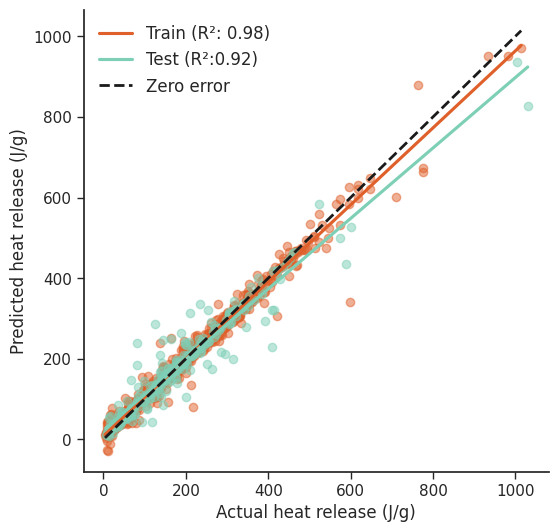

In [1049]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Prepare DataFrames for plotting
df_plot_test = pd.DataFrame({
    'heat release': y_test_unstd['heat release'],
    'heat_release_prediction': predictions_test_unstd[0]
})

df_plot_train = pd.DataFrame({
    'heat release': y_train_unstd['heat release'],
    'heat_release_prediction': predictions_train_unstd[0]
})

# Filter out rows with NaN values
df_filtered_test = df_plot_test.dropna()
df_filtered_train = df_plot_train.dropna()

# Set the aesthetic style of the plots
plt.style.use('seaborn-white')  # Use a clean white style
sns.set_style("ticks")  # Use ticks style for a more refined look
plt.rcParams['font.family'] = 'sans-serif'  # Use a sans-serif font for a modern look
plt.rcParams['font.size'] = 12  # Adjust font size for readability

# Create a combined plot for both training and testing datasets
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the size for a square aspect ratio

# Calculate and display R² scores
r2_test = r2_score(df_filtered_test['heat release'], df_filtered_test['heat_release_prediction'])
r2_train = r2_score(df_filtered_train['heat release'], df_filtered_train['heat_release_prediction'])


# Scatter plot for training data
sns.regplot(x='heat release', y='heat_release_prediction', data=df_filtered_train,
            scatter_kws={'alpha': 0.5, 'color': '#DF602A'}, line_kws={'color': '#DF602A', 'label': f'Train (R²: {r2_train:.2f})'},
            ax=ax, ci=0)

# Scatter plot for testing data
sns.regplot(x='heat release', y='heat_release_prediction', data=df_filtered_test,
            scatter_kws={'alpha': 0.5, 'color': '#7DCFB6'}, line_kws={'color': '#7DCFB6', 'label': f'Test (R²:{r2_test:.2f})'},
            ax=ax, ci=0)

# Add the zero error line last and use zorder to ensure it's on top
ax.plot([df_filtered_train['heat release'].min(), df_filtered_train['heat release'].max()], 
        [df_filtered_train['heat release'].min(), df_filtered_train['heat release'].max()], 
        'k--', lw=2, label='Zero error', zorder=5)

# Customize the plot
ax.set_xlabel('Actual heat release (J/g)')
ax.set_ylabel('Predicted heat release (J/g)')
ax.legend(frameon=False,prop={'size': 12})  # Remove the legend frame for a cleaner look
sns.despine()  # Remove the top and right spines

# Adjust ticks for a more refined appearance
ax.tick_params(axis='both', which='major', length=5, width=1, direction='out')

# Save the figure as a high-quality PNG file
plt.savefig('goodness_of_fit_heat_release.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [1052]:
model.save('90andupnewonesch.keras')  # Saves to the HDF5 format
